# Using the PhaseSpace, TimeHorizon & VectorField Classes.

## Preamble 

Recall that we define a Euclidean dynamical system with a set $X \subseteq \mathbb{R}^n$ and a vector field $X \to \mathbb{R}^n$ (or, for non-autonomous systems, $F: X \times T \to \mathbb{R}^n$ for some time horizon $T \subseteq \mathbb{R}$), supposing the equation $\dot{{\bf x}} = F({\bf x})$ (or, for non-autonomous systems, $\dot{{\bf x}} = F({\bf x}, t)$) holds over $X$ (or, for non-autonomous systems $X \times T$). In this short example, we concern ourselves with the programmatic representation of the set $X$. 

We define $X$ in abstract with the class `PhaseSpace` from the `core.euclidean` module. This class holds 3 attributes: `dimension`, `symbolic` and `constraint`, of types `int`, `sympy.set` and `Callable[[NDArray[np.float64]], bool]`. The purpose of dimension is obvious, it holds the value of $n$. The `symbolic` parameter utilises sympy to hold a symbolic representation of $X$, and the `constraint` parameter provides a functional representation of $X$, it's indicator functional. 

In constructing a `PhaseSpace` instance, it is only necessary to provide  `symbolic` or `callable`, though we recommend providing both. If only a symbolic representation is provided, we use lambdification provided by `sympy` for membership testing. This is provably slow. If only an indicator functional is provided, less insight can be inferred from string representations of our `PhaseSpace` instance. 

TIME HORIZON LOGIC HERE

## Overview

The `PhaseSpace` class provides:
- Factory methods for common geometric shapes (boxes, hyperspheres)
- Symbolic representation using SymPy for mathematical operations
- Callable constraints for fast numerical membership testing
- Custom constraint support for arbitrary sets
- Visualisation utils via `vis.euclidean` 
The `TimeHorizon` class provides:
- PROVIDED STUFF HERE.

For complete API documentation, see the [PhaseSpace API reference](../api/core/euclidean/phase_space.md) AND TIME HORIZON LINK HERE.

In [1]:
from PyDynSys.core.euclidean import PhaseSpace
import numpy as np
import sympy as syp

## PhaseSpace

### Factories

#### Full Euclidean Space

The `full()` factory creates a phase space representing $\mathbb{R}^n$ (unbounded Euclidean space).

In [2]:
# Create full 3D Euclidean space
real_plane = PhaseSpace.full(3)

print(f"Full phase space: {real_plane}")
print(f"Dimension: {real_plane.dimension}")

# All points are contained in R^n
test_point = np.array([1.0, -5.0, 10.0], dtype=np.float64)
print(f"\nPoint {test_point} is in real_plane: {real_plane.contains_point(test_point)}")

Full phase space: ProductSet(Reals, Reals, Reals)
Dimension: 3

Point [ 1. -5. 10.] is in real_plane: True


#### Box Constraints

The `box()` factory creates a box-constrained phase space $[a_1, b_1] \times \cdots \times [a_n, b_n] \subset \mathbb{R}^n$

In [3]:
# Create unit box [0, 1] × [0, 1] × [0, 1]
bounds = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], dtype=np.float64)
unit_box = PhaseSpace.box(bounds)

print(f"Unit box: {unit_box}")
print(f"Dimension: {unit_box.dimension}")

# Test membership
inside_point = np.array([0.5, 0.5, 0.5], dtype=np.float64)
outside_point = np.array([1.1, 0.5, 0.5], dtype=np.float64)
boundary_point = np.array([1.0, 1.0, 1.0], dtype=np.float64)  # On boundary

print(f"\nPoint {inside_point} is in unit_box: {unit_box.contains_point(inside_point)}")
print(f"Point {outside_point} is in unit_box: {unit_box.contains_point(outside_point)}")
print(f"Point {boundary_point} is in unit_box: {unit_box.contains_point(boundary_point)}")  # Closed intervals

Unit box: ProductSet(Interval(0.0, 1.00000000000000), Interval(0.0, 1.00000000000000), Interval(0.0, 1.00000000000000))
Dimension: 3

Point [0.5 0.5 0.5] is in unit_box: True
Point [1.1 0.5 0.5] is in unit_box: False
Point [1. 1. 1.] is in unit_box: True


#### Other Factories

The `PhaseSpace` class also provides:
- `closed_hypersphere(center, radius)` - Closed hypersphere $\{x \in \mathbb{R}^n : \lVert x - center\rVert < radius\}$
- `open_hypersphere(center, radius)` - Open hypersphere $\{x \in \mathbb{R}^n : \lVert x - center\rVert < radius\}$

For details on these and all other methods, see the [PhaseSpace API documentation](../api/core/euclidean/phase_space.md).

### Membership Testing

PhaseSpace provides two methods for membership testing:
- `contains_point(x)` - Check if a single point is in the phase space
- `contains_points(X)` - Check if all points in an array are in the phase space

In [4]:
# Create a set of test points
point_set = np.array([
    [0.5, 0.5, 0.5],  # Inside
    [1.0, 1.0, 1.0],  # On boundary
    [0.0, 0.0, 0.0],  # Corner
    [1.1, 0.5, 0.5]   # Outside
], dtype=np.float64)

print("Testing membership for unit_box:")
for i, point in enumerate(point_set):
    is_inside = unit_box.contains_point(point)
    print(f"  Point {i+1} {point}: {is_inside}")

print(f"\nAll points in unit_box: {unit_box.contains_points(point_set)}")
print(f"All points in real_plane: {real_plane.contains_points(point_set)}")

Testing membership for unit_box:
  Point 1 [0.5 0.5 0.5]: True
  Point 2 [1. 1. 1.]: True
  Point 3 [0. 0. 0.]: True
  Point 4 [1.1 0.5 0.5]: False

All points in unit_box: False
All points in real_plane: True


### Custom Constraints

We allow for phase spaces outside of the scope of our factories too. Consider, for example, ellipsoids.

In [5]:
# Custom ellipsoid: (x/2)^2 + (y/1)^2 + (z/1.5)^2 <= 1
# Semi-axes: [2, 1, 1.5], centered at origin
dimension = 3
semi_axes = np.array([2.0, 1.0, 1.5], dtype=np.float64)

# Create symbolic representation using SymPy
R_n = syp.Reals ** dimension
x = syp.symbols('x0 x1 x2', real=True)
ellipsoid_condition = sum((x[i] / semi_axes[i])**2 for i in range(dimension)) <= 1
ellipsoid_symbolic = syp.ConditionSet(syp.Tuple(*x), ellipsoid_condition, R_n)

# Create callable constraint for fast membership testing
ellipsoid_constraint = lambda x: bool(np.sum((x / semi_axes)**2) <= 1)

# Create PhaseSpace with both representations
custom_ellipsoid = PhaseSpace(
    dimension=dimension,
    symbolic_set=ellipsoid_symbolic,
    constraint=ellipsoid_constraint
)

print(f"Custom ellipsoid: {custom_ellipsoid}")
print(f"Dimension: {custom_ellipsoid.dimension}")

Custom ellipsoid: ConditionSet((x0, x1, x2), 0.25*x0**2 + 1.0*x1**2 + 0.444444444444444*x2**2 <= 1, ProductSet(Reals, Reals, Reals))
Dimension: 3


In [6]:
# Test membership in custom ellipsoid
test_points = np.array([
    [0.0, 0.0, 0.0],      # Center - inside
    [2.0, 0.0, 0.0],      # On x-axis boundary - inside
    [0.0, 1.0, 0.0],      # On y-axis boundary - inside
    [0.0, 0.0, 1.5],      # On z-axis boundary - inside
    [2.1, 0.0, 0.0],      # Outside x semi-axis
    [1.0, 0.5, 0.75],     # Inside ellipsoid (not on axes)
], dtype=np.float64)

print("Testing membership for custom ellipsoid:")
for i, point in enumerate(test_points):
    is_inside = custom_ellipsoid.contains_point(point)
    print(f"  Point {i+1} {point}: {is_inside}")

Testing membership for custom ellipsoid:
  Point 1 [0. 0. 0.]: True
  Point 2 [2. 0. 0.]: True
  Point 3 [0. 1. 0.]: True
  Point 4 [0.  0.  1.5]: True
  Point 5 [2.1 0.  0. ]: False
  Point 6 [1.   0.5  0.75]: True


### Visualization

For 2D phase spaces, we can visualize the set using the `plot_phase_space` function from `PyDynSys.vis`. This function creates a grid of points and tests membership using the constraint callable, then visualizes the result using `imshow` for efficient boolean visualization.

Note: `xlim` and `ylim` are required parameters - you must specify the viewing bounds explicitly.

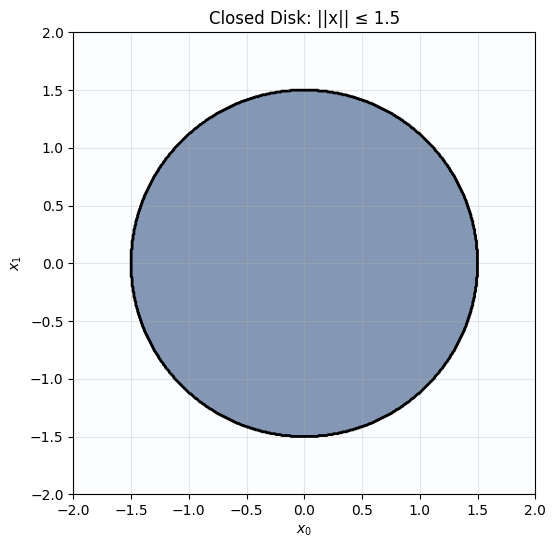

In [7]:
import matplotlib.pyplot as plt
from PyDynSys.vis import plot_phase_space

### --- Visualize a closed disk (circle) --- ###

center = np.array([0.0, 0.0], dtype=np.float64)
radius = 1.5
disk = PhaseSpace.closed_hypersphere(center, radius)

fig, ax = plt.subplots(figsize=(6, 6))
# increasing resolution for default=200 to 500, 200 is a tad blurry.
plot_phase_space(disk, xlim=(-2, 2), ylim=(-2, 2), ax=ax, resolution=500)
plt.title('Closed Disk: ||x|| ≤ 1.5')
plt.show()


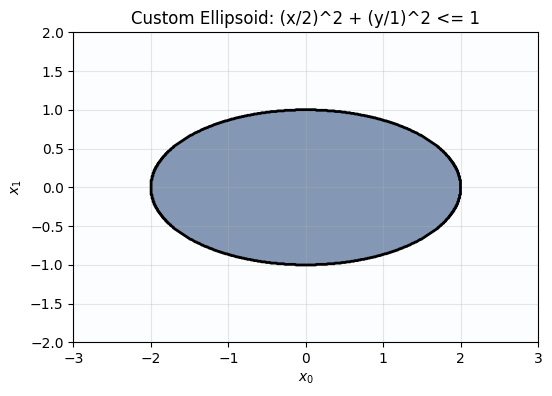

In [8]:
### --- Visualize a custom 2D ellipsoid --- ###

dimension_2d = 2
semi_axes_2d = np.array([2.0, 1.0], dtype=np.float64)

R_2 = syp.Reals ** dimension_2d
x_2d = syp.symbols('x0 x1', real=True)
ellipsoid_condition_2d = sum((x_2d[i] / semi_axes_2d[i])**2 for i in range(dimension_2d)) <= 1
ellipsoid_symbolic_2d = syp.ConditionSet(syp.Tuple(*x_2d), ellipsoid_condition_2d, R_2)

ellipsoid_constraint_2d = lambda x: bool(np.sum((x / semi_axes_2d)**2) <= 1)

custom_ellipsoid_2d = PhaseSpace(
    dimension=dimension_2d,
    symbolic_set=ellipsoid_symbolic_2d,
    constraint=ellipsoid_constraint_2d
)

fig, ax = plt.subplots(figsize=(6, 6))
# increasing resolution for default=200 to 500, 200 is a tad blurry.
plot_phase_space(custom_ellipsoid_2d, xlim=(-3, 3), ylim=(-2, 2), ax=ax, resolution=500)
plt.title('Custom Ellipsoid: (x/2)^2 + (y/1)^2 <= 1')
plt.show()

## Time Horizons 

Our `TimeHorizon` class provides factories: 

- real_line 
- closed_interval(t_min, t_max)
- open_interval(t_min, t_max)

has identical attributes, minus dimension, to `PhaseSpace` and identical (with points renamed to times) exposed methods. As with `PhaseSpace`, we recommend users provide both the constraint and symbolic representation for performance reasons, though we support the case where at least one, but not necessarily both, is provided. 

The logic is essentially identical to a phase space with dimension = 1, and as such we elect to leave experimentation with this class to the reader.

## Future Work 

In the near future, we aim to further implement the following methods for `PhaseSpace`: 

- volume (with `@property' decorator and caching ; rigorous if available, numerical via convex hull otherwise)
- union, intersection, symmetric difference, complement & other set theoretic operators (leveraging sympy toolkit & boolean logic for callables)
- numerical derivation (given points, compute convex hull; smoothing & padding logic desired)

And for `TimeHorizon`:

- length (with `@property' decorator and caching ; rigorous if available, numerical otherwise)
- union, intersection, symmetric difference, complement & other set theoretic operators (leveraging sympy toolkit & boolean logic for callables)
- numerical derivation (given points, compute bounds and express as union of closed intervals with optional padding)

We additionally seek to provide:

- `PyDynSys.vis` utils for 3d phase spaces, projections (e.g. PCA, chosen axis) for $n > 3$ dimension phase spaces and plotting support for simple scalar (1d) phase spaces; all of which are aggregated in the `plot_phase_space` util.
- Support for scalar `TimeHorizon` plots, though this is a triviality. 
- Support for `TimeHorizon` $\times$ `PhaseSpace` plots, particularly useful for analysing non-autonomous system predicates. 